# Séance 4 - Réseau récurrent

Dans cette séance nous allons entraîner un modèle à copier le style de poésie de Beaudelaire, spécifiquement l'oeuvre *Les fleurs du mal*. Ce TP est largement inspiré du cours du [CNAM](https://cedric.cnam.fr/~thomen/cours/US330X/tpRNNs.html) que l'on a adapté ici.

Pour cela, nous utiliserons le projet [Gutenberg](https://www.gutenberg.org) qui permet l'accès l'ensemble des oeuvres littéraires classique gratuitement. C'est sur ce dataset, entre autres, que les LLM s'entraînent.

Commençons par importer les packages dont nous aurons besoin.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

import tensorflow as tf
from tensorflow import keras

Après avoir chargé dans l'environnement le fichier .txt de poésie, nous devons le travailler un peu pour l'exploiter.

In [2]:
start = False
book = open("Beaudelaire.txt", 'r' , encoding = 'utf8')
lines = book.readlines()
verses = []

for line in lines:
 line = line.strip().lower()
 if("AU LECTEUR".lower() in line and start==False):
  start = True
 if("End of the Project Gutenberg EBook of Les Fleurs du Mal, by Charles Baudelaire".lower() in line):
  break
 if(start==False or len(line) == 0):
  continue
 verses.append(line)

book.close()
text = " ".join(verses)
characters = sorted(set([character for character in text]))
n_characters = len(characters)

On décide ici de le découper en séquence de 32 caractères et de se décaler d'un caractère à chaque fois. Nous allons donc prédire le caractère suivant à partir des 32 caractères précédents.
Construisons deux listes qui, une fois transformée, deviendront $X$ et $y$.

In [3]:
sequence_length = 32
stride = 1
sequences = []
y_character = []
for index in range(0, len(text) - sequence_length, stride):
 sequences.append(text[index:(index + sequence_length)])
 y_character.append(text[index + sequence_length])

Un réseau de neurone ne comprend pas le texte, donc nous devrons jongler entre nombre et caractères. Pour cela, nous créons deux dictionnaires pour traduire ces deux visions.

In [4]:
character_to_index = dict((character, index) for index, character in enumerate(characters))
index_to_character = dict((index, character) for index, character in enumerate(characters))

Nous sommes maintenant prêt pour renseigner $X$ et $y$.

In [5]:
X = np.zeros((len(sequences), sequence_length, n_characters), dtype=bool)
y = np.zeros((len(sequences), n_characters), dtype=bool)

for row, sequence in enumerate(sequences):
  for position, character in enumerate(sequence):
    X[row][position][character_to_index[character]] = True
  y[row][character_to_index[y_character[row]]] = True

Découpons à présent $X$ et $y$ en un jeu de test et un jeu d'entraînement.

In [6]:
train_size = 0.8
train_index = int(round(len(sequences)*train_size))
X_train = X[:train_index,:,:]
y_train = y[:train_index,:]

X_test = X[train_index:,:,:]
y_test = y[train_index:,:]

## Modélisation

Dans cet exemple, nous allons définir un réseau récurrent avec les neurones de bases : pas de LSTM ou GRU.

Un neurone *SimpleRNN* possède les mêmes attributs qu'un neurones classique en plus de deux paramètres majeurs:
* **return_sequences**: si l'on doit renvoyer la totalité de la séquence ou seulement la dernière valeur
* **unroll**: permet d'accélérer l'entraînement du réseau de neurone au prix de plus de mémoire impliquée


Il ne nous reste plus qu'à le définir.

In [8]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(128, return_sequences=True, activation="relu", kernel_initializer="he_normal", input_shape=(sequence_length, n_characters), unroll=True),
    keras.layers.LayerNormalization(),
    keras.layers.SimpleRNN(64, return_sequences=False, activation="relu", kernel_initializer="he_normal", unroll=True),
    keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(units=n_characters, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 32, 128)           23424     
                                                                 
 layer_normalization_1 (Lay  (None, 32, 128)           256       
 erNormalization)                                                
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 54)                3510      
                                                                 
Total params: 43702 (170.71 KB)
Trainable params: 43702 (170.71 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

Pour accélérer l'entraînement, nous décidons de choisir un batch size de 64 et d'utiliser AdamW comme optimizer.

Pour éviter l'overfitting, on se propose d'exploiter la mécanique d'*EarlyStopping*. A FAIRE

In [9]:
batch_size = 64
n_epochs = 20
learning_rate = 1e-3
weight_decay = 1e-3
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay), metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/20
1699/1699 [==============================] - 40s 21ms/step - loss: 2.1540 - accuracy: 0.3690 - val_loss: 1.9211 - val_accuracy: 0.4246
Epoch 2/20
1699/1699 [==============================] - 37s 22ms/step - loss: 1.8247 - accuracy: 0.4423 - val_loss: 1.8147 - val_accuracy: 0.4509
Epoch 3/20
1699/1699 [==============================] - 37s 22ms/step - loss: 1.7315 - accuracy: 0.4647 - val_loss: 1.7751 - val_accuracy: 0.4552
Epoch 4/20
1699/1699 [==============================] - 40s 23ms/step - loss: 1.6779 - accuracy: 0.4808 - val_loss: 1.7361 - val_accuracy: 0.4753
Epoch 5/20
1699/1699 [==============================] - 37s 22ms/step - loss: 1.6390 - accuracy: 0.4907 - val_loss: 1.7046 - val_accuracy: 0.4807
Epoch 6/20
1699/1699 [==============================] - 38s 22ms/step - loss: 1.6049 - accuracy: 0.4983 - val_loss: 1.6946 - val_accuracy: 0.4843
Epoch 7/20
1699/1699 [==============================] - 42s 24ms/step - loss: 1.5788 - accuracy: 0.5054 - val_loss: 1.7049 -

L'entraînement étant terminé, visualisons sa courbe d'entraînement.

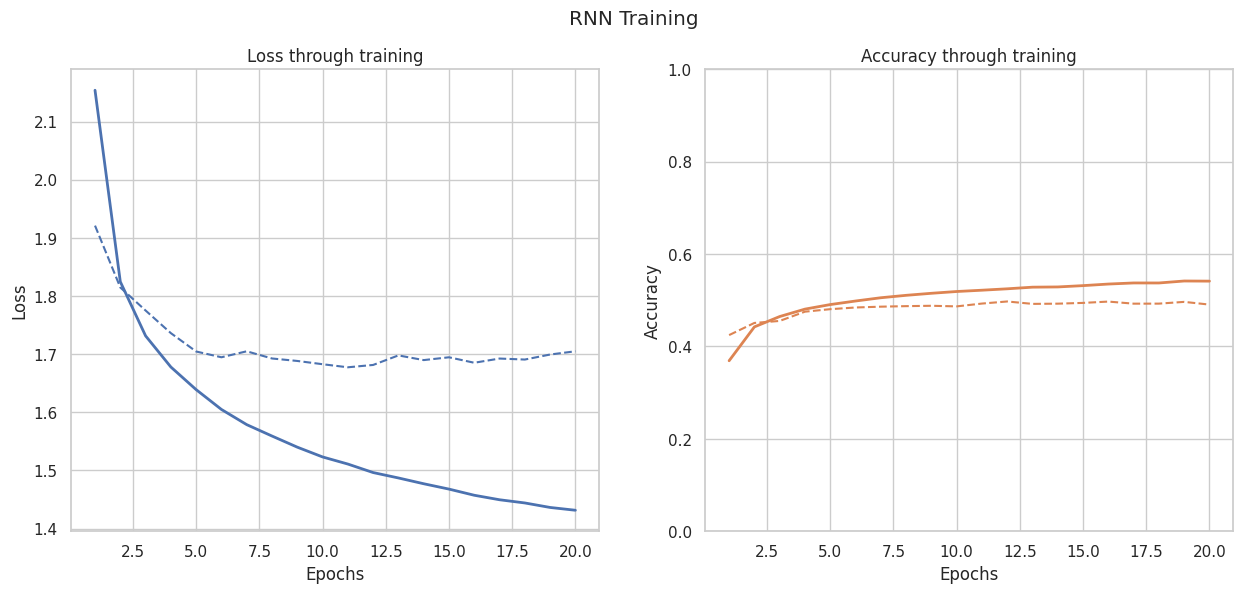

In [19]:
historic = pd.DataFrame(history.history)
figure, (axis_1, axis_2) = plt.subplots(1, 2, figsize=(15, 6))
epochs = range(1, n_epochs+1)

for index, (metric_name, axis) in enumerate(zip(["loss", "accuracy"], [axis_1, axis_2])):
  color = sns.color_palette()[index]
  axis.plot(epochs, historic[metric_name], lw=2, color=color)
  axis.plot(epochs, historic["val_" + metric_name], ls="--", color=color)

  if metric_name == "accuracy": axis.set_ylim(0, 1)
  axis.set_ylabel(metric_name.capitalize())
  axis.set_xlabel("Epochs")
  axis.set_title("%s through training" % metric_name.capitalize())


plt.suptitle("RNN Training")
plt.show()

On note un overfitting fort ! Il faudrait probablement mieux régulariser le réseau, réduire le learning rate est également une possibilité.
Sauvegardons le modèle pour pouvoir l'utiliser plus tard, ou sur un autre notebook par exemple.

In [21]:
def save_model(model, name):
  model_json = model.to_json()
  with open(name + ".json", "w") as json_file:
    json_file.write(model_json)
  model.save_weights(name+".h5")

save_model(model, "SimpleRNN")

Importons le modèle que l'on vient de sauvegarder sous un autre alias.

In [22]:
from keras.models import model_from_json


def load_model(name):
  with open(name + ".json", "r") as json_file:
    model = model_from_json(json_file.read())
  model.load_weights(name+".h5")
  return model


model_SimpleRNN = load_model("SimpleRNN")

Vérifions que les performances sont bien celles que nous connaissons:

In [14]:
model_SimpleRNN.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay),metrics=['accuracy'])
score = model_SimpleRNN.evaluate(X_test, y_test, verbose=0)
print("Test accuracy: %.02f%%" % (score[1]*100))

Test accuracy: 49.06%


## Génération de texte

On souhaite exploiter le modèle pour générer de la poésie dans le style de Beaudelaire.
On se propose de commencer par un bout d'un poème au hasard.

In [27]:
seed = 2025
sequence = ""
for index in range(sequence_length):
 character = index_to_character[np.argmax(X_train[seed, index, :])]
 sequence += character

print("Start sequence: " + sequence)

Start sequence: mère épouvantée et pleine de bla


Pour choisir le prochain caractère, nous pouvons simplement sélectionner le caractère le plus probable prédit par le modèle.
Cette approche peut amener le modèle à dégénérer. Nous allons ici exploiter le *temperature sampling*.

In [16]:
def sampling(probabilities, temperature=1.0):
 probabilities = np.asarray(probabilities).astype('float64')
 probabilities = pow(probabilities, 1.0 / temperature)
 probabilities /= np.sum(probabilities)
 probabilities = np.random.multinomial(n=1, pvals=probabilities, size=1)
 return np.argmax(probabilities)

Maintenant que nous sommes capables de sélectionner le prochain mot avec plus de justesse, il ne nous restes plus qu'à générer la suite de la phrase !

In [28]:
def generate_sequence(start, length, model, temperature=1):

  sequence = np.zeros((1, sequence_length, n_characters), dtype=bool)
  for position, character in enumerate(start):
    sequence[0][position][character_to_index[character]] = True

  generated_sequence = start

  for _ in range(length):
    probabilities = model.predict(sequence, verbose=0)[0]
    next_index = sampling(probabilities, temperature=temperature)
    character = index_to_character[next_index]
    generated_sequence += character
    for index in range(sequence_length-1): sequence[0, index, :] = sequence[0, index+1, :]
    sequence[0, sequence_length-1, :] = 0
    sequence[0, sequence_length-1, next_index] = 1
  return generated_sequence

In [29]:
generate_sequence(start=sequence, length=50, model=model_SimpleRNN, temperature=0.5)

"mère épouvantée et pleine de blasphème et fleurs et se voir les marche et l'orguei"

Dans le texte, la strophe était:

*Lorsque, par un décret des puissances suprêmes,
Le Poète apparaît en ce monde ennuyé,
Sa **mère épouvantée et pleine de bla**sphèmes
Crispe ses poings vers Dieu, qui la prend en pitié:*
